# True Zonal Mean

Calculate the 'true zonal mean' of a scalar quantity regardless of the horizontal mesh. Specifically calcualte the volume weighted mean along all grid cells whose centres fall within finite latitude intervals rather than the arithmetic mean of cells along the model's curvilinear grid. The method presented can also be used to re-grid models onto the same latitudinal grid and the general principles can be used to define any multidimensional sum or average using xhistogram.

**Requirements:** 
Select the `conda/analysis3-20.01` (or later) kernel.
This code should work for just about any MOM5 configuration since all we are grabbing is temeprature and standard grid information. 
You can swap temperature with any other scalar variable. You can also in principle swap latitude with another scalar.

Last updated by Jan Zika 8-4-2020

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from dask.distributed import Client
from xhistogram.xarray import histogram #This package has only recently been added to conda/analysis3-20.01

In [2]:
client = Client(n_workers=4)
client
session = cc.database.create_session()
#cc.start_cluster(diagnostics_port=8787)

Choose the run and the variable we want to average. I am using temperature but you can choose any scalar.

In [24]:
expt =  '025deg_jra55v13_ryf8485_gmredi6' #Choose any run
variable = 'temp' #any scalar variable where volume weighted averaging makes sense
variable_to_average = cc.querying.getvar(expt, variable, session, ncfile='ocean.nc')

First we will show the standard approach which is to take the arithmetic mean of all grid cells along the quasi-longitudinal coordinate. For MOM5's tri-polar grid this approach is in principle okay for the southern hemisphere where grid cell areas are constant at constant latitude. It doesn't though, take into account partial cells. 

For some scalar $T$ this average is an arithemtic mean given by

$$ \left<T\right>_{j,k} = \sum_{i=1}^{I}T_{i,j,k}/I$$

where $i$,$j$ and $k$ are the indicies in the $x$, $y$ and $z$ directions respectively of the curvilinear grid and $I$ is the number of indicies along the $x$ axis. 

Text(0.5, 1.0, 'x-coordinate arithmetic mean')

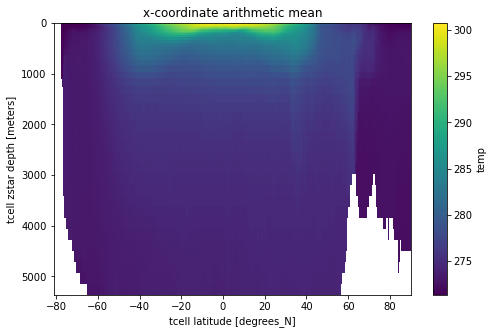

In [25]:
x_arith_mean = variable_to_average.groupby('time.year').mean(dim='time').mean(dim='xt_ocean')
plt.figure(figsize=(8,5))
x_arith_mean.sel(year=2000).plot(yincrease=False)
plt.title('x-coordinate arithmetic mean')

The main issue with this average is the 'latitude' coordinate may be meaningless near the north pole particulalrly when comparing to observational analysis or other models which will have either a regular grid or a different curvilinear grid. Even different versions of MOM might have different grids. 

Let us consider what the true zonal average looks like. Let is consider a set of latitude 'edges' $\{\phi'_{1/2},\phi'_{1+1/2},...,\phi'_{l-1/2},\phi'_{l+1/2},...,\phi'_{L+1/2}\}$ between which we want to compute an average of $T$ at $\{\phi'_{1},\phi'_{2},...,\phi'_{l},...,\phi'_{L}\}$ such that

$$ \overline{T}(\phi'_l,\sigma) = \frac{\iint_{\phi'_{l-1/2} < \phi \leq \phi'_{l+1/2}} T(\phi,\lambda,\sigma)\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma) dA}{\iint_{\phi'_{l-1/2} < \phi \leq \phi'_{l+1/2}}\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma) dA}.$$

where $\lambda$ is longitude and $\sigma$ is an arbitrary vertical coordinate. 

In discrete form this average is

$$\overline{T}_{l,k} = \frac{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j}T_{i,j,k}\Delta Z_{i,j,k}\Delta Area_{i,j}}{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j,k}\Delta Z_{i,j,k}\Delta Area_{i,j}}$$

where $\delta_{i,j} = 1$ if $\phi'_{l-1/2}<\phi_{i,j}\leq \phi'_{l+1/2}$ and $\delta_{i,j} = 0$ elsewhere, $\Delta Z$ is the grid cell vertical thickness and $\Delta Area$ is the grid cell horizontal area.

For our purposes we will use the edges of the models 'xt_ocean' coordinate to define $\phi'_{l+1/2}$ so the number of 'bins' $L$ will be the same as the length of the quasi-latitude coordinate ($J$). 

Fortunately, as you can see below, the two sums are weighted histograms (one for T times volume and the other for just volume) and these can be rapidly computed using xhistogram.

First lets load the scalar variable (latitude) we want to use as our coordinate then define the bin edges.

In [26]:
coord = 'geolat_t' #can be any scalar (2D, 3D, eulerian, lagrangian etc)
variable_as_coord = cc.querying.getvar(expt,coord,session, n=1) #might need ncfile='ocean.nc' if a tracer

#Define the coordinate bins as the latitude edges of the T-cells
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session, n=1)
#make numpy array (using .values) and add 1st edge at -90
bins =  np.insert(yu_ocean.values,0,np.array(-90),axis=0) 

#Alternatively we could just use some regular grid like this 
#coordbins =  np.linspace(-80, 90, 50)
#or use a grid from a different (coarser) model.

dzt = cc.querying.getvar(expt,'dzt',session, ncfile='ocean.nc') #thickness of cells
area_t = cc.querying.getvar(expt,'area_t',session, n=1) #area of cells
dVol = dzt*area_t #Volume of cells

Now let's compute the numerator and denominator of the equation above using xhistogram then the time and zonal mean

In [27]:
histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)),bins=[bins], weights=dVol,dim=['yt_ocean','xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)),bins=[bins], weights=dVol*variable_to_average,dim=['yt_ocean','xt_ocean'])
coord_mean = (histTVolCoordDepth/histVolCoordDepth).groupby('time.year').mean(dim='time')

Now we can plot the results which thankfully retain all the darray info on variables and axis etc.

Text(0.5, 1.0, 'True zonal mean')

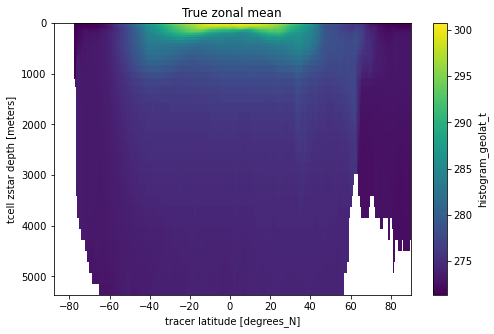

In [28]:
plt.figure(figsize=(8,5))
coord_mean.sel(year=2000).plot(yincrease=False)
plt.title('True zonal mean')

Since we used the same bin edges as the standard yt_ocean coordinate we can take a difference between the arithmetic mean along the model's x-axis and our mean along grid cells within latitude bands. The main differences are near the North Pole where the grid is furthest for being regular. There are also differences near the Antacrtic Shelf suggesting partial cells also matter.

Text(0.5, 1.0, 'True zonal minus x-coordinate mean')

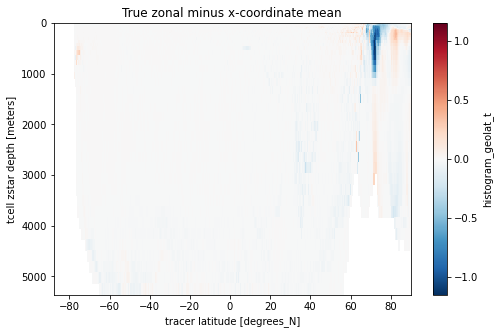

In [29]:
zonal_minus_x_mean = coord_mean.sel(year=2000)-x_arith_mean.sel(year=2000).values
plt.figure(figsize=(8,5))
zonal_minus_x_mean.plot(yincrease=False)
plt.title('True zonal minus x-coordinate mean')